Loading and preparing data...

Training Logistic Regression...

Training Logistic Regression...
Logistic Regression Validation AUC: 0.643

Training Random Forest...
Logistic Regression Validation AUC: 0.643

Training Random Forest...
Random Forest Validation AUC: 0.549

Training XGBoost...
Random Forest Validation AUC: 0.549

Training XGBoost...
XGBoost Validation AUC: 0.604

Best model: Logistic Regression (AUC = 0.643)
XGBoost Validation AUC: 0.604

Best model: Logistic Regression (AUC = 0.643)


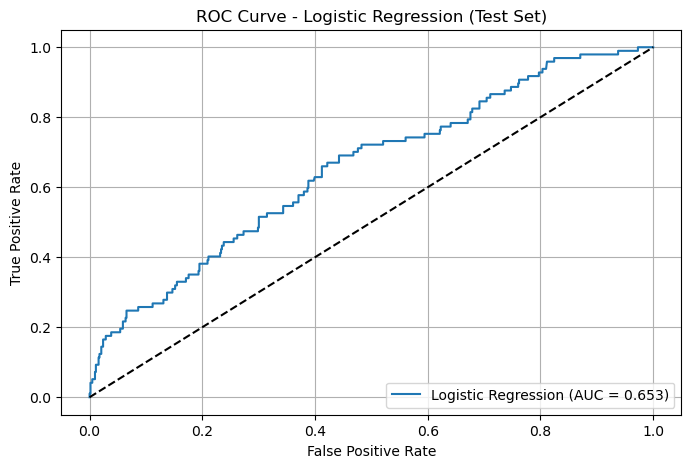

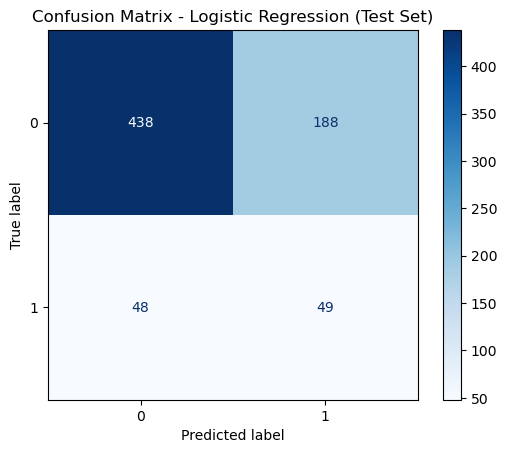


Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.70      0.79       626
           1       0.21      0.51      0.29        97

    accuracy                           0.67       723
   macro avg       0.55      0.60      0.54       723
weighted avg       0.81      0.67      0.72       723


Performing time-series analysis...


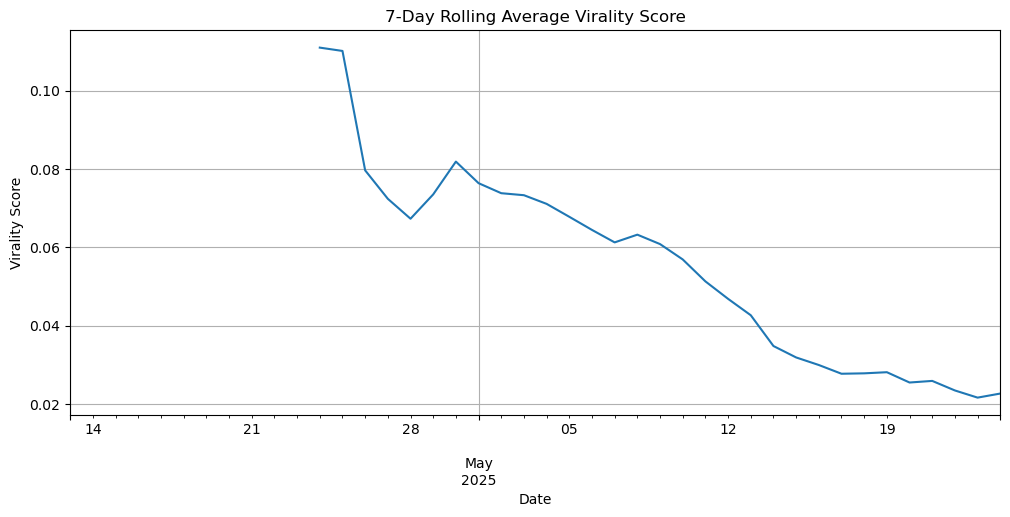


Running ARIMA forecast...


c:\Users\USER\.conda\envs\wif3009\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\USER\.conda\envs\wif3009\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\USER\.conda\envs\wif3009\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\USER\.conda\envs\wif3009\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

                                   SARIMAX Results                                   
Dep. Variable:     virality_score_normalized   No. Observations:                   40
Model:                        ARIMA(7, 1, 2)   Log Likelihood                  59.460
Date:                       Thu, 05 Jun 2025   AIC                            -98.919
Time:                               14:04:52   BIC                            -82.284
Sample:                                    0   HQIC                           -92.951
                                        - 40                                         
Covariance Type:                         opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2253      0.356     -0.633      0.527      -0.923       0.473
ar.L2         -0.3492      0.234     -1.495      0.135      -0.807       0.

c:\Users\USER\.conda\envs\wif3009\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\USER\.conda\envs\wif3009\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


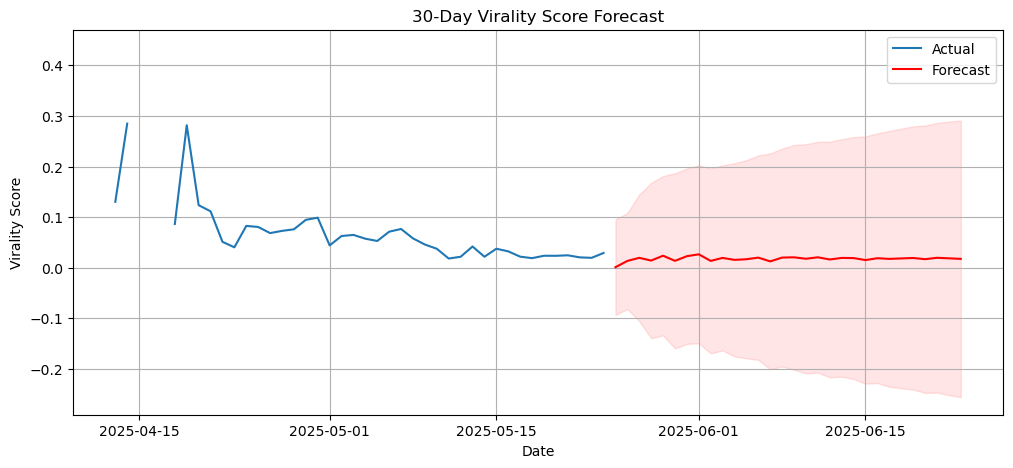

In [9]:
#======================
# TIKTOK TREND PREDICTION (USING VIRALITY SCORE)
# ======================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import shap
from statsmodels.tsa.arima.model import ARIMA
import xgboost as xgb

# ======================
# DATA LOADING & FEATURE ENGINEERING
# ======================

print("Loading and preparing data...")
df = pd.read_csv('data/processed/tiktok_categorized.csv')

# Convert timestamp and sort by time
df['create_time'] = pd.to_datetime(df['create_time'])
df = df.sort_values('create_time')

def calculate_rolling_virality_score(df, window_days=30):
    """Calculate virality score using only historical data"""
    result = pd.DataFrame()
    window = pd.Timedelta(days=window_days)
    
    for date in df['create_time'].unique():
        # Get historical and current data
        historical_data = df[df['create_time'] < date]
        current_data = df[df['create_time'] == date].copy()
        
        if len(historical_data) > 100:
            recent_data = historical_data[historical_data['create_time'] > (date - window)]
            corr_views_likes = recent_data['plays'].corr(recent_data['likes'])
            corr_views_comments = recent_data['plays'].corr(recent_data['comments'])
            corr_views_shares = recent_data['plays'].corr(recent_data['shares'])
        else:
            corr_views_likes = corr_views_comments = corr_views_shares = 0.5
            
        # Calculate virality score
        current_data['virality_score'] = (
            current_data['plays'] + 
            (1 - corr_views_likes) * current_data['likes'] + 
            (1 - corr_views_comments) * current_data['comments'] + 
            (1 - corr_views_shares) * current_data['shares']
        )
        
        result = pd.concat([result, current_data])
    
    # Rolling normalization
    result['virality_score_normalized'] = result.groupby(
        pd.Grouper(key='create_time', freq=f'{window_days}D')
    )['virality_score'].transform(
        lambda x: (x - x.min()) / (x.max() - x.min()) if len(x) > 1 else x
    )
    
    return result

def calculate_rolling_author_metrics(df, window_days=30):
    """Calculate author metrics using only historical data"""
    result = pd.DataFrame()
    window = pd.Timedelta(days=window_days)
    
    for date in df['create_time'].unique():
        historical_data = df[df['create_time'] < date]
        current_data = df[df['create_time'] == date].copy()
        
        for author in current_data['author'].unique():
            author_history = historical_data[historical_data['author'] == author]
            recent_history = author_history[author_history['create_time'] > (date - window)]
            
            if len(recent_history) > 0:
                metrics = {
                    'author_avg_virality': recent_history['virality_score_normalized'].mean(),
                    'author_max_virality': recent_history['virality_score_normalized'].max(),
                    'author_total_videos': len(recent_history),
                    'author_viral_ratio': (recent_history['virality_score_normalized'] > 0.8).mean()
                }
            else:
                metrics = {
                    'author_avg_virality': 0,
                    'author_max_virality': 0,
                    'author_total_videos': 0,
                    'author_viral_ratio': 0
                }
            
            current_data.loc[current_data['author'] == author, metrics.keys()] = metrics.values()
        
        result = pd.concat([result, current_data])
    
    return result

# Apply rolling calculations
df = calculate_rolling_virality_score(df)
df = calculate_rolling_author_metrics(df)

# Fill missing descriptions and convert to string
df['clean_description'] = df['clean_description'].fillna('').astype(str)

# Calculate threshold using only historical data up to 80% quantile
train_end = df['create_time'].quantile(0.8)
virality_threshold = df[df['create_time'] <= train_end]['virality_score_normalized'].quantile(0.80)
df['is_trending'] = (df['virality_score_normalized'] >= virality_threshold).astype(int)

# Time-based train/validation/test split (after 'is_trending' is created)
val_end = df['create_time'].quantile(0.9)
train_data = df[df['create_time'] <= train_end]
val_data = df[(df['create_time'] > train_end) & (df['create_time'] <= val_end)]
test_data = df[df['create_time'] > val_end]

# Group rare authors
author_counts = train_data['author'].value_counts()
rare_authors = author_counts[author_counts < 10].index
df['author'] = df['author'].replace(rare_authors, 'other')

# ======================
# FEATURE DEFINITION
# ======================

numerical_features = [
    # Time features
    'create_hour',
    
    # Content features
    'hashtag_count',
    'description_length',
    'sentiment_polarity',
    
    # Author features
    'author_avg_virality',
    'author_max_virality',
    'author_total_videos',
    'author_viral_ratio'
]

categorical_features = [
    'day_of_week',
    'is_weekend',
    'time_period',
    'author'
]

text_feature = 'clean_description'
use_text_feature = True

# ======================
# MODEL TRAINING
# ======================

# Preprocessing pipeline
transformers = [
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
]

if use_text_feature:
    transformers.append((
        'text',
        TfidfVectorizer(max_features=100, stop_words='english'),
        text_feature
    ))

preprocessor = ColumnTransformer(transformers)

# Define models
models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', max_iter=1000),
    'Random Forest': RandomForestClassifier(class_weight='balanced', n_jobs=-1),
    'XGBoost': xgb.XGBClassifier(scale_pos_weight=5, eval_metric='logloss')
}

# Train and evaluate models
results = {}
best_auc = 0
best_model = None
best_model_name = None

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    pipeline = ImbPipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('model', model)
    ])
    
    # Fit on training data
    pipeline.fit(train_data[numerical_features + categorical_features + ([text_feature] if use_text_feature else [])],
                train_data['is_trending'])
    
    # Predict on validation set
    val_pred_proba = pipeline.predict_proba(
        val_data[numerical_features + categorical_features + ([text_feature] if use_text_feature else [])])[:, 1]
    
    # Calculate AUC
    val_auc = roc_auc_score(val_data['is_trending'], val_pred_proba)
    results[name] = val_auc
    
    print(f"{name} Validation AUC: {val_auc:.3f}")
    
    if val_auc > best_auc:
        best_auc = val_auc
        best_model = pipeline
        best_model_name = name

print(f"\nBest model: {best_model_name} (AUC = {best_auc:.3f})")

# ======================
# FINAL EVALUATION
# ======================

# Get predictions on test set
X_test = test_data[numerical_features + categorical_features + ([text_feature] if use_text_feature else [])]
y_test = test_data['is_trending']
y_test_pred = best_model.predict(X_test)
y_test_proba = best_model.predict_proba(X_test)[:, 1]

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f'{best_model_name} (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve - {best_model_name} (Test Set)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plot confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title(f'Confusion Matrix - {best_model_name} (Test Set)')
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

# ======================
# TIME SERIES ANALYSIS
# ======================

print("\nPerforming time-series analysis...")
daily_virality = df.set_index('create_time')['virality_score_normalized'].resample('D').mean()

# Plot rolling average
plt.figure(figsize=(12, 5))
daily_virality.rolling(7).mean().plot(
    title="7-Day Rolling Average Virality Score",
    xlabel="Date",
    ylabel="Virality Score"
)
plt.grid(True)
plt.show()

# ARIMA forecast
print("\nRunning ARIMA forecast...")
model = ARIMA(daily_virality.dropna(), order=(7, 1, 2), seasonal_order=(0, 0, 0, 7))
arima_results = model.fit()
print(arima_results.summary())

# Generate and plot forecast
forecast_obj = arima_results.get_forecast(steps=30)
forecast_df = forecast_obj.conf_int(alpha=0.05)
forecast_df['mean'] = forecast_obj.predicted_mean.values

last_date = daily_virality.dropna().index[-1]
forecast_index = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)
forecast_df.index = forecast_index

plt.figure(figsize=(12, 5))
plt.plot(daily_virality, label='Actual')
plt.plot(forecast_df['mean'], label='Forecast', color='red')
plt.fill_between(forecast_df.index, forecast_df.iloc[:, 0], forecast_df.iloc[:, 1], color='red', alpha=0.1)
plt.title("30-Day Virality Score Forecast")
plt.xlabel("Date")
plt.ylabel("Virality Score")
plt.legend()
plt.grid(True)
plt.show()

In [10]:
# ======================
# EXPORT PROCESSED DATA WITH ORIGINAL AUTHORS FOR QUESTION 5
# ======================

# Load original data to preserve all original columns and author names
original_df = pd.read_csv('data/processed/tiktok_categorized.csv')
original_df['create_time'] = pd.to_datetime(original_df['create_time'])
original_df = original_df.sort_values('create_time')

# Add new features to the original data and export
new_feature_columns = [
    'virality_score', 'virality_score_normalized', 'is_trending',
    'author_avg_virality', 'author_max_virality', 'author_total_videos', 'author_viral_ratio'
]

# Extract the new features from the processed dataframe
new_features = df[['video_id'] + new_feature_columns].copy()

# Merge with original data to preserve all original columns and add new features
final_export_df = original_df.merge(new_features, on='video_id', how='left')

# Export to CSV
export_path = 'data/processed/tiktok_enhanced_features.csv'
final_export_df.to_csv(export_path, index=False)